# Деревья решений и ансамбли

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

np.random.seed(42)

## 1. Подготовка данных

In [59]:
data = load_breast_cancer()
X = data.data
y = data.target

print("Значения целевого признака:", np.unique(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('Размерности наборов данных:')
print('X_train:', X_train.shape, 'y_train:', y_train.shape)
print('X_test:', X_test.shape, 'y_test:', y_test.shape)

Значения целевого признака: [0 1]
Размерности наборов данных:
X_train: (398, 30) y_train: (398,)
X_test: (171, 30) y_test: (171,)


## 2. Реализация собственного дерева решений

In [60]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, *, value=None):
        """
        Параметры:
        - feature_index: Индекс признака, по которому производится разделение.
        - threshold: Пороговое значение для разделения.
        - left: Левый дочерний узел.
        - right: Правый дочерний узел.
        - value: Значение, если узел является листом.
        """
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTreeClassifierCustom:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None):
        """
        Параметры:
        - max_depth: Максимальная глубина роста дерева.
        - min_samples_split: Минимальное количество образцов для разделения внутреннего узла.
        - min_samples_leaf: Минимальное количество образцов в листовом узле.
        - max_features: Количество признаков для рассмотрения при поиске лучшего разделения (используется в ансамблях).
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.root = None

    def fit(self, X, y):
        self.n_classes_ = len(np.unique(y))
        self.n_features_ = X.shape[1]
        self.root = self._grow_tree(X, y, depth=0)

    def _grow_tree(self, X, y, depth):
        num_samples, num_features = X.shape
        num_labels = len(np.unique(y))
        
        # Проверка критериев останова
        if (depth >= self.max_depth if self.max_depth is not None else False) or \
           num_labels == 1 or \
           num_samples < self.min_samples_split:
            # Создание листового узла с наиболее частым классом
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # Выбор подмножества признаков, если установлен max_features
        feature_indices = np.arange(num_features)
        if self.max_features is not None and self.max_features < num_features:
            feature_indices = np.random.choice(num_features, self.max_features, replace=False)

        # Поиск лучшего разделения
        best_feat, best_thresh = self._best_split(X, y, feature_indices)
        
        # Если не найдено допустимое разделение, создаем листовой узел
        if best_feat is None:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        
        # Разделение набора данных
        indices_left = X[:, best_feat] < best_thresh
        X_left, y_left = X[indices_left], y[indices_left]
        X_right, y_right = X[~indices_left], y[~indices_left]
        
        # Проверка критерия min_samples_leaf
        if len(y_left) < self.min_samples_leaf or len(y_right) < self.min_samples_leaf:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # Рекурсивное выращивание левой и правой ветвей
        left_child = self._grow_tree(X_left, y_left, depth + 1)
        right_child = self._grow_tree(X_right, y_right, depth + 1)
        
        return Node(feature_index=best_feat, threshold=best_thresh, left=left_child, right=right_child)

    def _best_split(self, X, y, feature_indices):
        best_gain = -1
        split_idx, split_thresh = None, None
        
        # Вычисление примеси Джини для текущего узла
        parent_gini = self._gini(y)

        for feat in feature_indices:
            X_column = X[:, feat]
            # Рассмотрение всех уникальных значений как потенциальных порогов
            thresholds = np.unique(X_column)
            for thresh in thresholds:
                # Разделение данных
                left_idx = X_column < thresh
                right_idx = ~left_idx
                
                if len(y[left_idx]) == 0 or len(y[right_idx]) == 0:
                    continue
                
                # Вычисление взвешенной примеси
                gain = parent_gini - (
                    (len(y[left_idx]) / len(y)) * self._gini(y[left_idx]) +
                    (len(y[right_idx]) / len(y)) * self._gini(y[right_idx])
                )

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat
                    split_thresh = thresh

        return split_idx, split_thresh

    def _gini(self, y):
        m = len(y)
        if m == 0:
            return 0
        counts = np.bincount(y)
        prob_sq = (counts / m) ** 2
        return 1 - np.sum(prob_sq)

    def _most_common_label(self, y):
        counts = np.bincount(y)
        return np.argmax(counts)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value
        if x[node.feature_index] < node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

    def get_tree_height(self):
        def height(node):
            if node is None or node.value is not None:
                return 0
            return 1 + max(height(node.left), height(node.right))
        return height(self.root)

## 3. Анализ библиотечного дерева решений

Минимальное количество образцов для разделения = 2, Высота дерева = 7
Минимальное количество образцов для разделения = 3, Высота дерева = 7
Минимальное количество образцов для разделения = 4, Высота дерева = 7
Минимальное количество образцов для разделения = 5, Высота дерева = 7
Минимальное количество образцов для разделения = 6, Высота дерева = 7
Минимальное количество образцов для разделения = 7, Высота дерева = 7
Минимальное количество образцов для разделения = 8, Высота дерева = 7
Минимальное количество образцов для разделения = 9, Высота дерева = 7
Минимальное количество образцов для разделения = 10, Высота дерева = 7
Минимальное количество образцов для разделения = 11, Высота дерева = 7
Минимальное количество образцов для разделения = 12, Высота дерева = 7
Минимальное количество образцов для разделения = 13, Высота дерева = 7
Минимальное количество образцов для разделения = 14, Высота дерева = 6


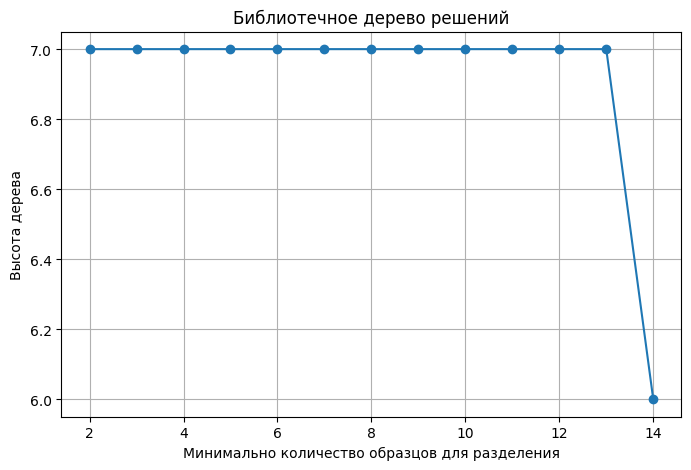

In [61]:
min_samples_split_values = range(2, 15)
tree_heights = []

for min_samples in min_samples_split_values:
    clf = DecisionTreeClassifier(min_samples_split=min_samples, random_state=42)
    clf.fit(X_train, y_train)
    
    height = clf.tree_.max_depth
    tree_heights.append(height)
    
    print(f'Минимальное количество образцов для разделения = {min_samples}, Высота дерева = {height}')

# Строим график зависимости
plt.figure(figsize=(8, 5))
plt.plot(min_samples_split_values, tree_heights, marker='o', linestyle='-')
plt.xlabel('Минимально количество образцов для разделения')
plt.ylabel('Высота дерева')
plt.title('Библиотечное дерево решений')
plt.grid(True)
plt.show()

## 4. Анализ собственного дерева решений

минимальное количество образцов для разделения = 2, Высота дерева = 7
минимальное количество образцов для разделения = 3, Высота дерева = 7
минимальное количество образцов для разделения = 4, Высота дерева = 7
минимальное количество образцов для разделения = 5, Высота дерева = 7
минимальное количество образцов для разделения = 6, Высота дерева = 7
минимальное количество образцов для разделения = 7, Высота дерева = 7
минимальное количество образцов для разделения = 8, Высота дерева = 7
минимальное количество образцов для разделения = 9, Высота дерева = 7
минимальное количество образцов для разделения = 10, Высота дерева = 7
минимальное количество образцов для разделения = 11, Высота дерева = 7
минимальное количество образцов для разделения = 12, Высота дерева = 7
минимальное количество образцов для разделения = 13, Высота дерева = 7
минимальное количество образцов для разделения = 14, Высота дерева = 6


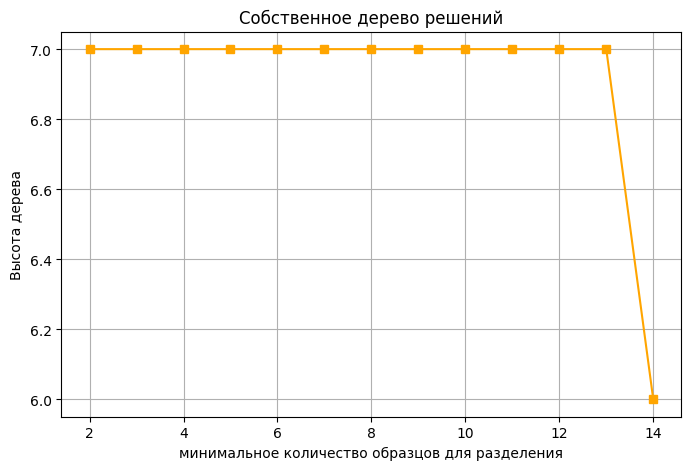

In [62]:
min_samples_split_vals_custom = range(2, 15)
custom_tree_heights = []

for min_samples in min_samples_split_vals_custom:
    custom_tree = DecisionTreeClassifierCustom(max_depth=100, # Достаточно большой, чтобы не ограничивать рост
                                                min_samples_split=min_samples,
                                                min_samples_leaf=1)
    custom_tree.fit(X_train, y_train)
    
    height = custom_tree.get_tree_height()
    custom_tree_heights.append(height)
    
    print(f'минимальное количество образцов для разделения = {min_samples}, Высота дерева = {height}')

plt.figure(figsize=(8, 5))
plt.plot(list(min_samples_split_vals_custom), custom_tree_heights, marker='s', linestyle='-', color='orange')
plt.xlabel('минимальное количество образцов для разделения')
plt.ylabel('Высота дерева')
plt.title('Собственное дерево решений')
plt.grid(True)
plt.show()

## 5. Зависимость точности от высоты дерева

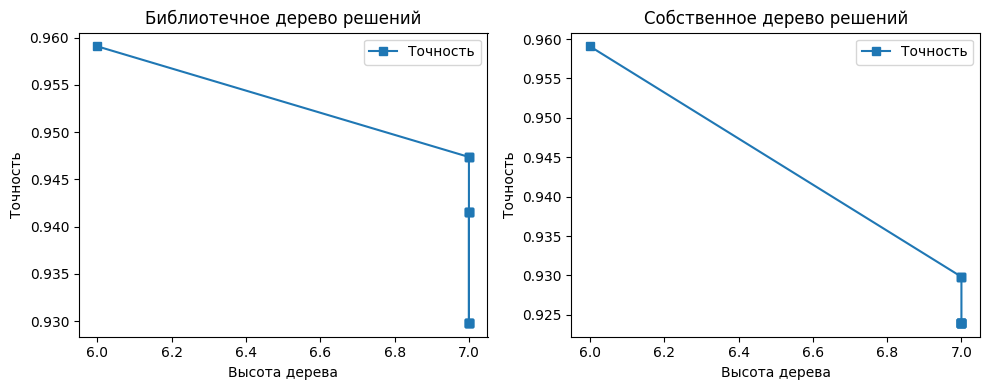

In [63]:
lib_heights = []
lib_train_acc = []
lib_test_acc = []

for min_samples in min_samples_split_values:
    clf = DecisionTreeClassifier(min_samples_split=min_samples, random_state=42)
    clf.fit(X_train, y_train)
    height = clf.tree_.max_depth
    lib_heights.append(height)
    
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    lib_test_acc.append(accuracy_score(y_test, y_test_pred))

custom_heights = []
custom_train_acc = []
custom_test_acc = []

for min_samples in min_samples_split_vals_custom:
    custom_tree = DecisionTreeClassifierCustom(max_depth=100, 
                                                min_samples_split=min_samples,
                                                min_samples_leaf=1)
    custom_tree.fit(X_train, y_train)
    height = custom_tree.get_tree_height()
    custom_heights.append(height)
    
    y_train_pred = custom_tree.predict(X_train)
    y_test_pred = custom_tree.predict(X_test)
    custom_test_acc.append(accuracy_score(y_test, y_test_pred))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(lib_heights, lib_test_acc, marker='s', label='Точность')
plt.xlabel('Высота дерева')
plt.ylabel('Точность')
plt.title('Библиотечное дерево решений')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(custom_heights, custom_test_acc, marker='s', label='Точность')
plt.xlabel('Высота дерева')
plt.ylabel('Точность')
plt.title('Собственное дерево решений')
plt.legend()

plt.tight_layout()
plt.show()

## 6. Случайный лес

In [64]:
class RandomForestClassifierCustom:
    def __init__(self, n_estimators=10, max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='sqrt'):
        """  
        Параметры:
        - n_estimators: Количество деревьев в лесу.
        - max_depth, min_samples_split, min_samples_leaf: Гиперпараметры для каждого дерева решений.
        - max_features: Количество признаков для рассмотрения при поиске лучшего разделения.
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        self.n_features_ = X.shape[1]
        self.trees = []
        
        if self.max_features == 'sqrt':
            max_feat = int(np.sqrt(self.n_features_))
        elif isinstance(self.max_features, int):
            max_feat = self.max_features
        else:
            max_feat = self.n_features_

        for _ in range(self.n_estimators):
            indices = np.random.choice(len(X), size=len(X), replace=True)
            X_sample = X[indices]
            y_sample = y[indices]
            
            tree = DecisionTreeClassifierCustom(max_depth=self.max_depth,
                                                min_samples_split=self.min_samples_split,
                                                min_samples_leaf=self.min_samples_leaf,
                                                max_features=max_feat)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])

        predictions = []
        for i in range(X.shape[0]):
            counts = np.bincount(tree_preds[:, i], minlength=self.trees[0]._traverse_tree(np.zeros(self.n_features_), self.trees[0].root))
            predictions.append(np.argmax(counts))
        return np.array(predictions)

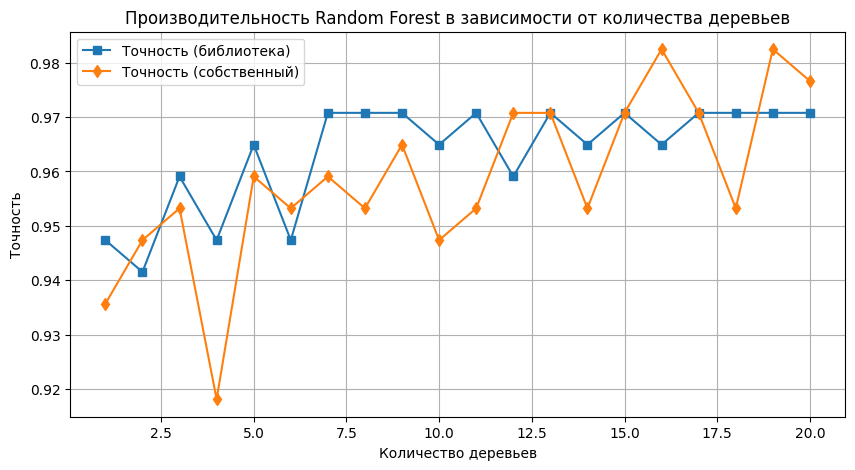

In [65]:
n_trees_range = range(1, 21)

lib_rf_train_acc = []
lib_rf_test_acc = []

for n in n_trees_range:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    lib_rf_test_acc.append(accuracy_score(y_test, rf.predict(X_test)))

custom_rf_train_acc = []
custom_rf_test_acc = []

for n in n_trees_range:
    custom_rf = RandomForestClassifierCustom(n_estimators=n,
                                              max_depth=10,
                                              min_samples_split=2,
                                              min_samples_leaf=1,
                                              max_features='sqrt')
    custom_rf.fit(X_train, y_train)
    custom_rf_test_acc.append(accuracy_score(y_test, custom_rf.predict(X_test)))

plt.figure(figsize=(10, 5))
plt.plot(list(n_trees_range), lib_rf_test_acc, marker='s', label='Точность (библиотека)')
plt.plot(list(n_trees_range), custom_rf_test_acc, marker='d', label='Точность (собственный)')
plt.xlabel('Количество деревьев')
plt.ylabel('Точность')
plt.title('Производительность Random Forest в зависимости от количества деревьев')
plt.legend()
plt.grid(True)
plt.show()

## 7. Бустинг с бинарной целевой переменной

In [ ]:
class AdaBoostClassifierCustom:
    def __init__(self, n_estimators=50, learning_rate=1.0):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.learners = []
        self.learner_weights = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        y_transformed = np.where(y == 0, -1, 1)
        
        sample_weights = np.ones(n_samples) / n_samples
        
        self.learners = []
        self.learner_weights = []
        
        for _ in range(self.n_estimators):
            # Создание взвешенной выборки с повторением
            bootstrap_indices = np.random.choice(n_samples, n_samples, p=sample_weights)
            X_bootstrap = X[bootstrap_indices]
            y_bootstrap = y[bootstrap_indices]
            
            stump = DecisionTreeClassifierCustom(max_depth=1, 
                                               min_samples_split=2,
                                               min_samples_leaf=1)
            stump.fit(X_bootstrap, y_bootstrap)
            
            predictions = stump.predict(X)
            pred_transformed = np.where(predictions == 0, -1, 1)
            
            incorrect = (pred_transformed != y_transformed)
            error = np.sum(sample_weights * incorrect)
            
            # Обработка крайних случаев
            error = np.clip(error, 1e-15, 1 - 1e-15)
            
            # Вычисление веса пня с коррекцией смещения
            alpha = self.learning_rate * 0.5 * np.log((1 - error) / error)
            
            sample_weights *= np.exp(-alpha * y_transformed * pred_transformed)
            
            # Нормализация весов
            sum_weights = np.sum(sample_weights)
            if sum_weights > 0:
                sample_weights /= sum_weights
            else:
                sample_weights = np.ones(n_samples) / n_samples
            
            self.learners.append(stump)
            self.learner_weights.append(alpha)

    def predict(self, X):
        # Получение решений от пней
        n_samples = X.shape[0]
        scores = np.zeros(n_samples)
        
        for learner, alpha in zip(self.learners, self.learner_weights):
            pred = learner.predict(X)
            pred_transformed = np.where(pred == 0, -1, 1)
            scores += alpha * pred_transformed
        
        # Преобразование оценок в бинарное решение
        return np.where(scores >= 0, 1, 0)

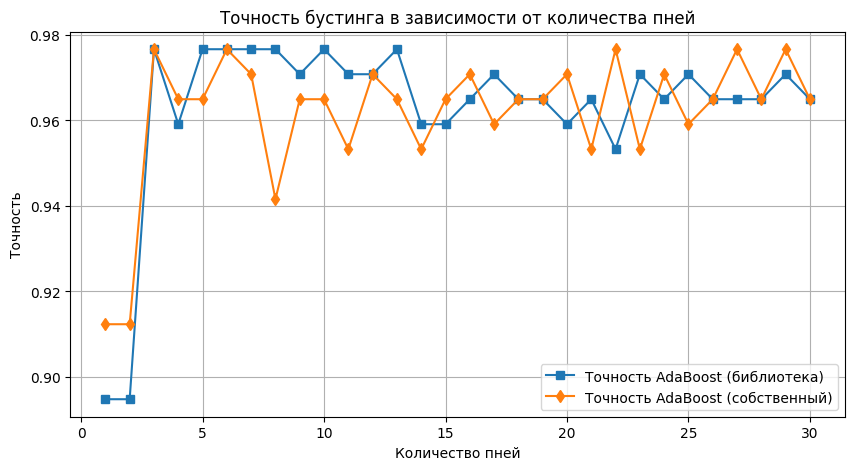

In [ ]:
n_estimators_range = range(1, 31)

lib_ada_train_acc = []
lib_ada_test_acc = []

for n in n_estimators_range:
    ada = AdaBoostClassifier(n_estimators=n, random_state=42)
    ada.fit(X_train, y_train)
    lib_ada_test_acc.append(accuracy_score(y_test, ada.predict(X_test)))

custom_ada_train_acc = []
custom_ada_test_acc = []

for n in n_estimators_range:
    custom_ada = AdaBoostClassifierCustom(n_estimators=n, learning_rate=1.0)
    custom_ada.fit(X_train, y_train)
    custom_ada_test_acc.append(accuracy_score(y_test, custom_ada.predict(X_test)))

plt.figure(figsize=(10, 5))
plt.plot(list(n_estimators_range), lib_ada_test_acc, marker='s', label='Точность AdaBoost (библиотека)')
plt.plot(list(n_estimators_range), custom_ada_test_acc, marker='d', label='Точность AdaBoost (собственный)')
plt.xlabel('Количество пней')
plt.ylabel('Точность')
plt.title('Точность бустинга в зависимости от количества пней')
plt.legend()
plt.grid(True)
plt.show()